## Sampler template

This notebook contains the basic syntax required to run a chain. We set up a mock data object, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from chainconsumer import ChainConsumer
# our own modules
from lace.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.likelihood import likelihood
from lace.sampler import emcee_sampler
import time

/home/chris/.local/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=15
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

will drop sim number 15 from emulator


In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 1.7654E-09, n_s = 9.6590E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Set up emulator training set
z_max=4
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type="k_bin",passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /home/chris/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 261 points
Optimised


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [6]:
#free_param_limits=[[1.1e-09, 3.19e-09], [0.89, 1.05],[-0.2, 0.2]]
#free_param_names=["As","ns","ln_tau_0"]

## Set up likelihood object
free_param_names=["Delta2_star","n_star","ln_tau_0"]
free_param_limits=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2]]
prior=None ## None for uniform prior, otherwise this value sets the width of the Gaussian within the unit prior volume
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=prior)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [7]:
## Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,
                        free_param_names=free_param_names,verbose=False,
                        nwalkers=10,
                        save_chain=False, ## Small test run, don't create a save folder
                        progress=True)

In [8]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

Delta2_star 0.36034233479911815 0.24 0.47
n_star -2.299511628221455 -2.352 -2.25
ln_tau_0 0.0 -0.2 0.2


In [9]:
n_burn_in=0
n_steps=200 ## Max number of steps to run

start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|██████████| 200/200 [01:37<00:00,  2.06it/s]

Sampling took 98.1 seconds


 /home/chris/.local/lib/python3.8/site-packages/lace-0.1.0-py3.8.egg/lace/sampler/emcee_sampler.py:713: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


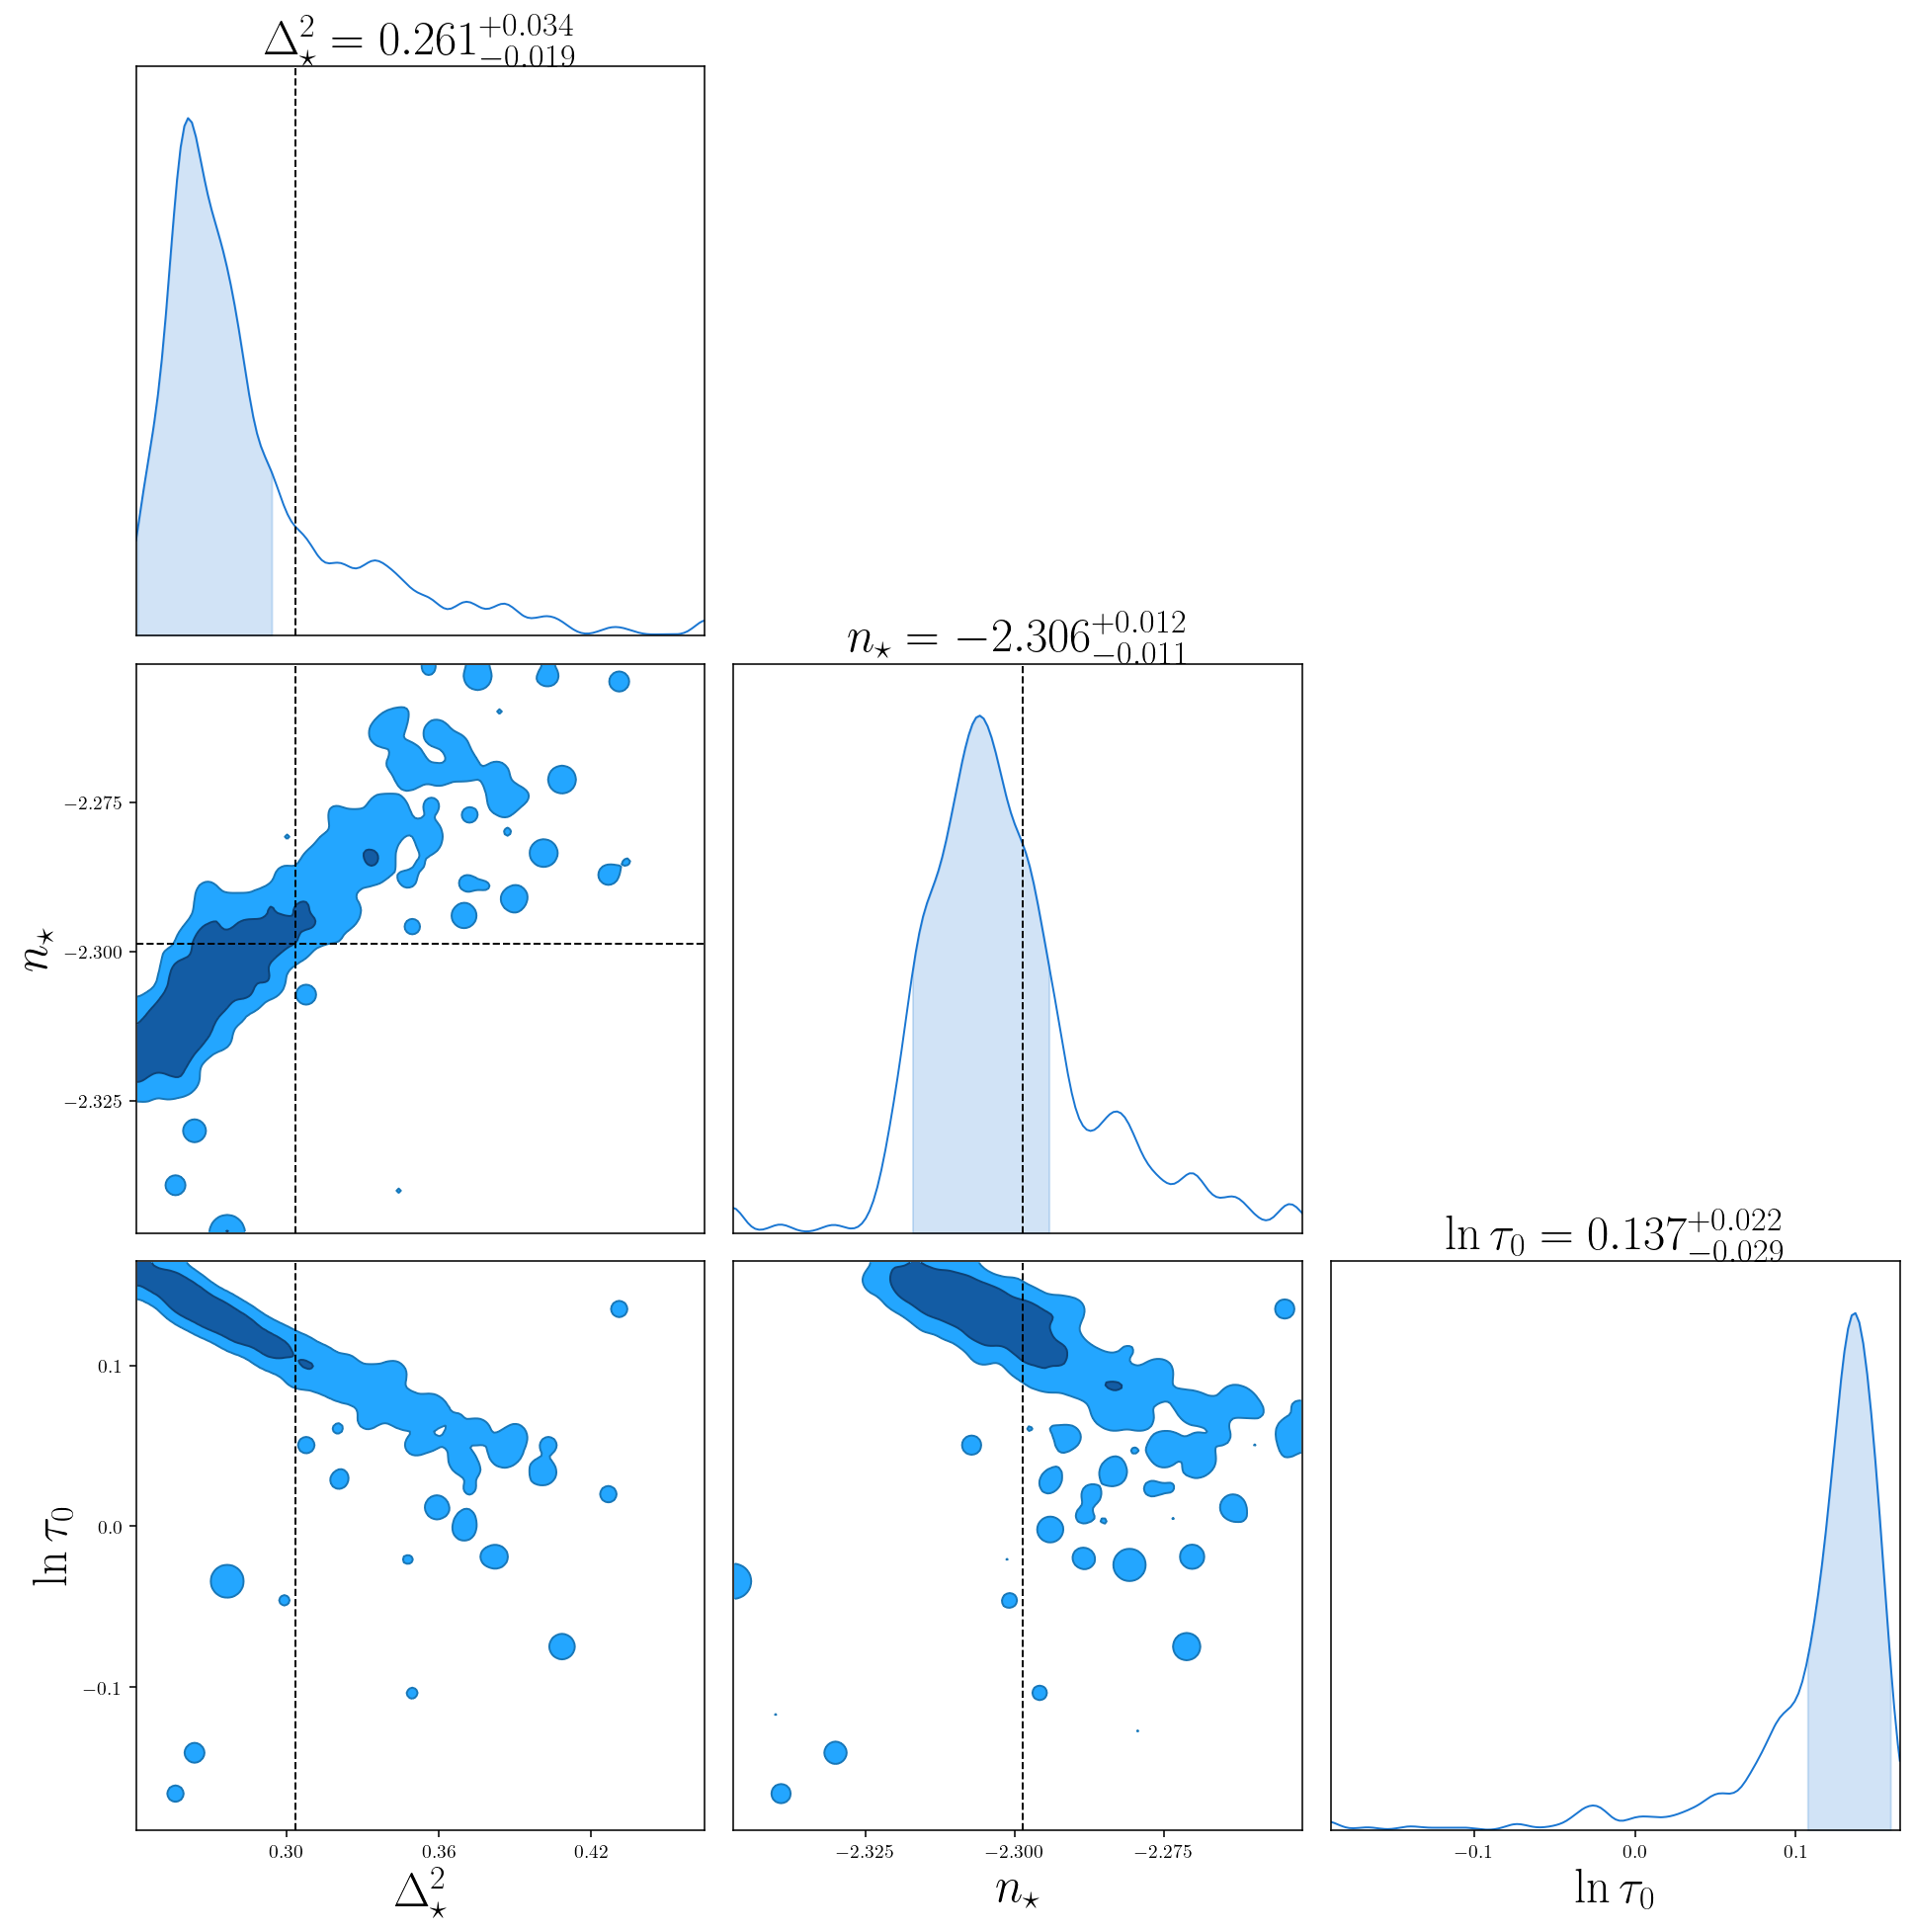

In [10]:
sampler.plot_corner()